In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

Truncation: sample noise vector from truncated normal distribution (after training) 

In [3]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    return torch.Tensor(truncated_noise)

Mapping network (map noise vector z to intermediate noise vector)

In [4]:
class MappingLayers(nn.Module):
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
        )

    def forward(self, noise):
        return self.mapping(noise)

Random noise injection (occurs before AdaIN blocks)

In [5]:
class InjectNoise(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.weight = nn.Parameter(
        torch.randn((1, channels, 1, 1)) 
    )
  
  def forward(self, image):
    noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3]) # image has shape (n_samples, channels, width, height) 
    noise = torch.randn(noise_shape, device=image.device)
    return image + self.weight * noise 

Adaptive Instance Normalization 

In [6]:
class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        self.instance_norm = nn.InstanceNorm2d(channels)

        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image

Progressive growing

In [7]:
class MicroStyleGANGeneratorBlock(nn.Module):

    def __init__(self, in_chan, out_chan, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample = use_upsample

        if self.use_upsample:
            self.upsample = nn.Upsample((starting_size, starting_size), mode="bilinear")
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1) 
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)


    def forward(self, x, w):
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x

In [8]:
class MicroStyleGANGenerator(nn.Module):

    def __init__(self, 
                 z_dim, 
                 map_hidden_dim,
                 w_dim,
                 in_chan,
                 out_chan, 
                 kernel_size, 
                 hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.block0 = MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)
        self.block1 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8)
        self.block2 = MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16)

        self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
        self.alpha = 0.2
  
    def upsample_to_match_size(self, smaller_image, bigger_image):
        return F.interpolate(smaller_image, size=bigger_image.shape[-2:], mode='bilinear')

    def forward(self, noise, return_intermediate=False):
        x = self.starting_constant
        w = self.map(noise)
        x = self.block0(x, w)
        x_small = self.block1(x, w)
        x_small_image = self.block1_to_image(x_small)
        x_big = self.block2(x_small, w) 
        x_big_image = self.block2_to_image(x_big)
        x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) 
        
        interpolation = torch.lerp(x_small_upsample, x_big_image, self.alpha)
        
        if return_intermediate:
            return interpolation, x_small_upsample, x_big_image
        return interpolation

In [9]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_truncated_noise(test_samples, z_dim, truncation))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


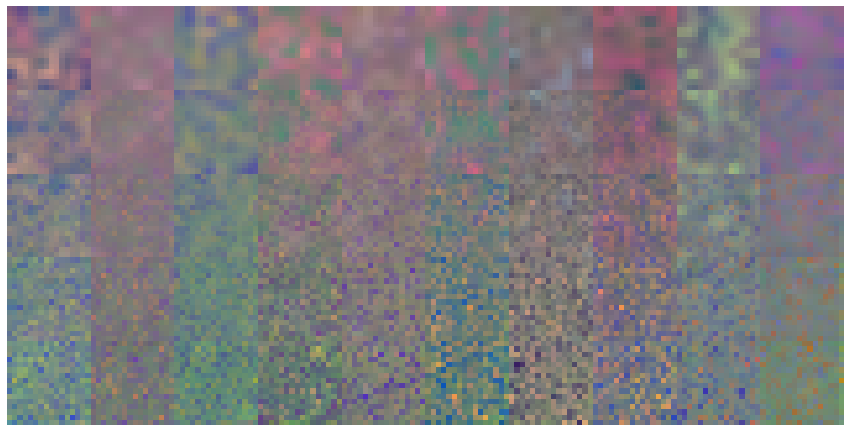

In [10]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()